# `LOGISTIC REGRESSION`

In [18]:
import sys
from pathlib import Path
import joblib
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.data_loader import (
    load_splits
)
import time
import numpy as np
import pandas as pd

from sklearn.model_selection import  StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


FIGURES_DIR = ROOT / "reports" / "figures"

In [2]:
# Загружаю сплиты данных
data = load_splits(scaled=False,encoded_y=True)
X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

### Обучаем Логистичискую Регресию на исходных признаках исользуя GreadSercCV

In [3]:
pipe = Pipeline([
    ("scaler",StandardScaler()),
    ("clf",LogisticRegression(max_iter=3000,random_state=42))
])

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

param_grid = {
    "clf__C": np.logspace(-3, 3, 7),
    
}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    refit=True
)

t0 = time.perf_counter()
gs.fit(X_train,y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'clf__C': array([1.e-03...e+02, 1.e+03])}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1_macro'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is al

In [4]:
# Извликаю лучшую модель,параметры
log_reg = gs.best_estimator_
best_params = gs.best_params_

In [22]:
# Сохраняю лучшую модель
ARTIFACTS_DIR = Path("../models").resolve()

joblib.dump(log_reg, ARTIFACTS_DIR / "log_reg.pkl")

['C:\\Users\\AlexK\\OneDrive\\Рабочий стол\\Классификаци типов личности\\models\\log_reg.pkl']

In [6]:
print(f"Лучшие параметры: {best_params}")
print(f"Время обучения лучшей модели: {gs.refit_time_:.2f} секунд")

Лучшие параметры: {'clf__C': np.float64(0.1)}
Время обучения лучшей модели: 0.05 секунд


In [15]:
y_pred = log_reg.predict(X_test)

In [8]:
accuracy =  accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
report = classification_report(y_test, y_pred)

In [35]:
# Веса признаков по классам с наибольшим влиянием(топ-10)

model = log_reg.named_steps['clf']
feature_names = log_reg.feature_names_in_

coef = pd.DataFrame(model.coef_, columns=feature_names,index=model.classes_)

for cls in model.classes_:
    s = coef.loc[cls]
    (pd.DataFrame({
        "coef": s.loc[top],
        "abs_coef": s.loc[top].abs()
    }).sort_values("abs_coef", ascending=False))



`Ambivert` — TOP-10 признаков увиличиваюшие/уменьшаюшие вероятность класса
| feature                  |      coef | abs_coef |
| ------------------------ | --------: | -------: |
| sports_interest          | -0.096136 | 0.096136 |
| online_social_usage      |  0.082203 | 0.082203 |
| curiosity                | -0.079752 | 0.079752 |
| excitement_seeking       |  0.079539 | 0.079539 |
| organization             |  0.076823 | 0.076823 |
| decision_speed           | -0.076271 | 0.076271 |
| work_style_collaborative | -0.060606 | 0.060606 |
| planning                 | -0.055835 | 0.055835 |
| public_speaking_comfort  |  0.055168 | 0.055168 |
| empathy                  |  0.051002 | 0.051002 |

`Extrovert` — TOP-10 признаков увиличиваюшие/уменьшаюшие вероятность класса
| feature                 |      coef | abs_coef |
| ----------------------- | --------: | -------: |
| party_liking            |  1.455840 | 1.455840 |
| alone_time_preference   | -1.181199 | 1.181199 |
| talkativeness           |  1.145807 | 1.145807 |
| excitement_seeking      |  1.090376 | 1.090376 |
| public_speaking_comfort |  1.077857 | 1.077857 |
| social_energy           |  1.040612 | 1.040612 |
| deep_reflection         | -0.913390 | 0.913390 |
| risk_taking             |  0.909707 | 0.909707 |
| adventurousness         |  0.877663 | 0.877663 |
| reading_habit           | -0.831026 | 0.831026 |

`Introvert` — TOP-10 признаков увиличиваюшие/уменьшаюшие вероятность класса
| feature                 |      coef | abs_coef |
| ----------------------- | --------: | -------: |
| party_liking            | -1.484787 | 1.484787 |
| alone_time_preference   |  1.216777 | 1.216777 |
| excitement_seeking      | -1.169914 | 1.169914 |
| public_speaking_comfort | -1.133025 | 1.133025 |
| talkativeness           | -1.119019 | 1.119019 |
| social_energy           | -1.036209 | 1.036209 |
| deep_reflection         |  0.903921 | 0.903921 |
| adventurousness         | -0.876363 | 0.876363 |
| risk_taking             | -0.872983 | 0.872983 |
| reading_habit           |  0.852718 | 0.852718 |



In [ ]:

global_imp = coef.abs().mean(axis=0).sort_values(ascending=False)

### 10 признаков с наибольшим влиянием по всем классам(по модулю)
| feature | importance |
|---|---:|
| party_liking | 0.989858 |
| alone_time_preference | 0.811185 |
| excitement_seeking | 0.779943 |
| talkativeness | 0.763871 |
| public_speaking_comfort | 0.755350 |
| social_energy | 0.693741 |
| deep_reflection | 0.608927 |
| risk_taking | 0.606471 |
| adventurousness | 0.585109 |
| reading_habit | 0.568478 |

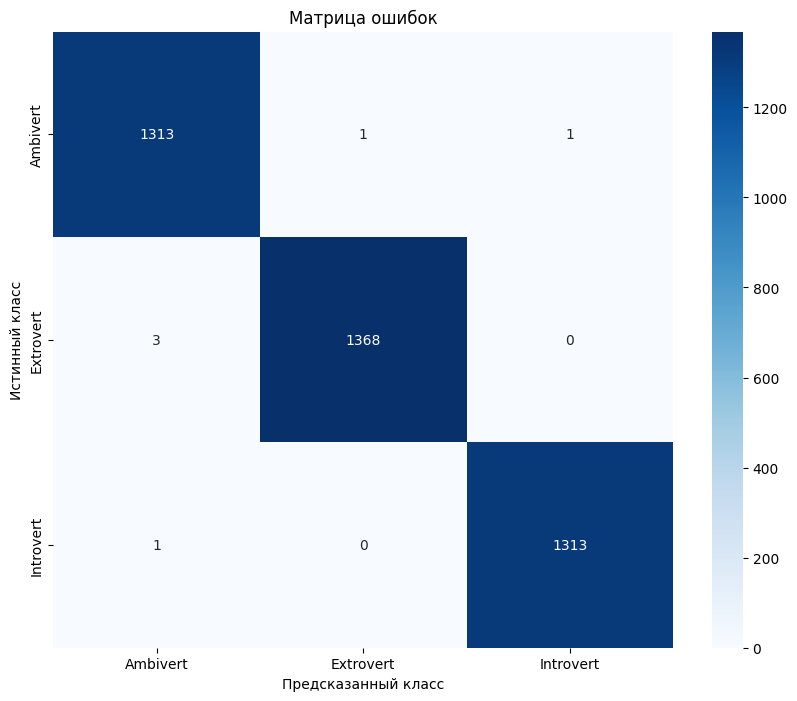

In [20]:
# строим матрицу ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Ambivert", "Extrovert", "Introvert"], yticklabels=["Ambivert", "Extrovert", "Introvert"])
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Матрица ошибок")
plt.savefig(FIGURES_DIR / "log_reg_Confusion_matrix", dpi=300, bbox_inches='tight')
plt.show()


### `Метрики`
### LogisticRegression with Regularization strength (0.1)


| Метрика | Значение |
|---|---:|
| TEST accuracy | 0.9985 |
| TEST f1_macro | 0.9984998252398108 |
| Время обучения (сек) | 0.09 |

### Classification report

| Класс | Precision | Recall | F1-score | Support |
|---:|---:|---:|---:|---:|
| `Ambivert` | 1.00 | 1.00 | 1.00 | 1315 |
| `Extrovert` | 1.00 | 1.00 | 1.00 | 1371 |
| `Introvert` | 1.00 | 1.00 | 1.00 | 1314 |
| **accuracy** |  |  | **1.00** | **4000** |
| **macro avg** | **1.00** | **1.00** | **1.00** | **4000** |
| **weighted avg** | **1.00** | **1.00** | **1.00** | **4000** |

### Модель демонстрирует почти идеальную классификацию: 3994/4000 верных ответов, всего 6 ошибок.

### Как и ожидалось при Иследовании данных модель НЕ путает Introver и Extrovert.

### Все зафиксированные ошибки связаны с классом Ambivert, что указывает на его промежуточную природу и частичное пересечение признаков с двумя другими классами.